# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2471c17a9f6c4286ae18beabee2af879ab555bd908241511eb286102caaf6c9b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=9bb4120b05ba7c7a0a928e6bc87a734385c3860b54f72c90e03463607a268c38
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = (OutConv(n_filters, n_classes))
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 246: 


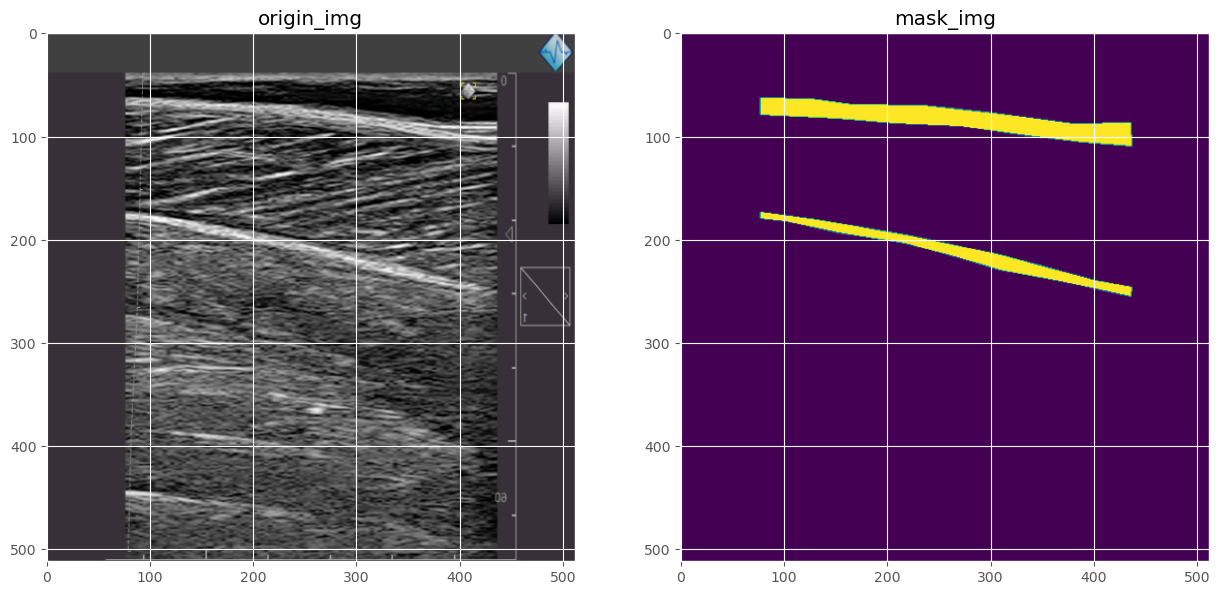

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCELoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)[0]
            dice_score += criterion(mask_pred, mask_true[0].float())
#             dice_score += dice_loss((mask_pred > 0.5).float(), mask_true[0])
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true[0].long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    print("Validation round IoU Score {}".format(iou_score / max(num_val_batches, 1)))
    return (dice_score / max(num_val_batches, 1), iou_score / max(num_val_batches, 1))

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    
     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCELoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
#     iou_metric = smp.metrics.IoU(threshold=0.5),
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
#                     loss += dice_loss((masks_pred > 0.5).float(), true_masks)

#                     iou = iou_metric(true_masks, (masks_pred > 0.5).float())
#                     if n_classes == 1:
#                         loss = criterion(masks_pred, true_masks.float())
#                         loss += dice_loss(F.sigmoid(masks_pred), true_masks.float(), multiclass=False)
#                     else:
                        
#                         loss = criterion(masks_pred, true_masks)
#                         loss += dice_loss(
#                             F.softmax(masks_pred, dim=1).float(),
#                             F.one_hot(true_masks, n_classes).permute(0, 3, 1, 2).float(),
#                             multiclass=True
#                         )
#                     iou = iou_metric(true_masks, (masks_pred > 0.5).float())
                    
                tp, fp, fn, tn = smp.metrics.get_stats(masks_pred[0], true_masks[0].long(), mode='binary', threshold=0.5)
                iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    
    train(model, device)

    

Let's use 2 GPUs!


wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231005_085607-w23lvaju
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run happy-energy-68
wandb: ⭐️ View project at https://wandb.ai/torwayland/U-Net
wandb: 🚀 View run at https://wandb.ai/torwayland/U-Net/runs/w23lvaju
Epoch 1/60:  20%|█▉        | 90/456 [00:25<00:58,  6.22img/s, loss (batch)=0.55] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.42batch/s]


Validation round IoU Score 0.23633050918579102


Epoch 1/60:  39%|███▉      | 180/456 [00:54<00:47,  5.77img/s, loss (batch)=0.443]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.34batch/s]


Validation round IoU Score 0.30307430028915405


Epoch 1/60:  59%|█████▉    | 270/456 [01:23<00:32,  5.68img/s, loss (batch)=0.376]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation round IoU Score 0.5133700370788574


Epoch 1/60:  79%|███████▉  | 360/456 [01:54<00:17,  5.61img/s, loss (batch)=0.349]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.5297941565513611


Epoch 1/60:  99%|█████████▊| 450/456 [02:24<00:01,  5.64img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.4856128692626953


Epoch 2/60:  18%|█▊        | 84/456 [00:14<01:05,  5.70img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.43600645661354065


Epoch 2/60:  38%|███▊      | 174/456 [00:44<00:49,  5.68img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.5581832528114319


Epoch 2/60:  58%|█████▊    | 264/456 [01:14<00:34,  5.64img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.5545491576194763


Epoch 2/60:  78%|███████▊  | 354/456 [01:44<00:18,  5.57img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.5351489186286926


Epoch 2/60:  97%|█████████▋| 444/456 [02:14<00:02,  5.54img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.5710515379905701


Epoch 3/60:  17%|█▋        | 78/456 [00:13<01:07,  5.63img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.5640542507171631


Epoch 3/60:  37%|███▋      | 168/456 [00:43<00:50,  5.67img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.5876867771148682


Epoch 3/60:  57%|█████▋    | 258/456 [01:13<00:35,  5.58img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.4895536005496979


Epoch 3/60:  76%|███████▋  | 348/456 [01:44<00:19,  5.68img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.5971353054046631


Epoch 3/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.68img/s, loss (batch)=0.306]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation round IoU Score 0.5631935000419617


Epoch 4/60:  16%|█▌        | 72/456 [00:12<01:05,  5.82img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation round IoU Score 0.537315845489502


Epoch 4/60:  36%|███▌      | 162/456 [00:42<00:51,  5.74img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.5857387185096741


Epoch 4/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.75img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6033205986022949


Epoch 4/60:  75%|███████▌  | 342/456 [01:42<00:19,  5.76img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6092075705528259


Epoch 4/60:  95%|█████████▍| 432/456 [02:12<00:04,  5.59img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.49326634407043457


Epoch 5/60:  14%|█▍        | 66/456 [00:11<01:09,  5.60img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6139293313026428


Epoch 5/60:  34%|███▍      | 156/456 [00:41<00:56,  5.27img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.5898206830024719


Epoch 5/60:  54%|█████▍    | 246/456 [01:11<00:38,  5.39img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6155164241790771


Epoch 5/60:  74%|███████▎  | 336/456 [01:42<00:20,  5.74img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6070600748062134


Epoch 5/60:  93%|█████████▎| 426/456 [02:12<00:05,  5.72img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6016978025436401


Epoch 6/60:  13%|█▎        | 60/456 [00:10<01:09,  5.73img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6170039176940918


Epoch 6/60:  33%|███▎      | 150/456 [00:40<00:53,  5.70img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.599638819694519


Epoch 6/60:  53%|█████▎    | 240/456 [01:10<00:38,  5.66img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6039426326751709


Epoch 6/60:  72%|███████▏  | 330/456 [01:40<00:22,  5.58img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.58443284034729


Epoch 6/60:  92%|█████████▏| 420/456 [02:10<00:06,  5.82img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6133572459220886


Epoch 7/60:  12%|█▏        | 54/456 [00:09<01:11,  5.59img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6154220700263977


Epoch 7/60:  32%|███▏      | 144/456 [00:39<00:54,  5.67img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation round IoU Score 0.4056336581707001


Epoch 7/60:  51%|█████▏    | 234/456 [01:09<00:39,  5.67img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6116418838500977


Epoch 7/60:  71%|███████   | 324/456 [01:39<00:23,  5.71img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation round IoU Score 0.6026322841644287


Epoch 7/60:  91%|█████████ | 414/456 [02:09<00:07,  5.81img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation round IoU Score 0.6250923871994019


Epoch 8/60:  11%|█         | 48/456 [00:08<01:12,  5.65img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation round IoU Score 0.6299100518226624


Epoch 8/60:  30%|███       | 138/456 [00:38<00:56,  5.65img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.4929829239845276


Epoch 8/60:  50%|█████     | 228/456 [01:08<00:40,  5.68img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation round IoU Score 0.6269350647926331


Epoch 8/60:  70%|██████▉   | 318/456 [01:38<00:24,  5.62img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6222174167633057


Epoch 8/60:  89%|████████▉ | 408/456 [02:08<00:08,  5.77img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation round IoU Score 0.6275920867919922


Epoch 9/60:   9%|▉         | 42/456 [00:07<01:14,  5.53img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation round IoU Score 0.6210105419158936


Epoch 9/60:  29%|██▉       | 132/456 [00:37<01:01,  5.28img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation round IoU Score 0.6324033141136169


Epoch 9/60:  49%|████▊     | 222/456 [01:07<00:45,  5.09img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.30575746297836304


Epoch 9/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.60img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6194724440574646


Epoch 9/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.65img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6268331408500671


Epoch 10/60:   8%|▊         | 36/456 [00:06<01:13,  5.69img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.6383900046348572


Epoch 10/60:  28%|██▊       | 126/456 [00:36<00:58,  5.68img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation round IoU Score 0.6368568539619446


Epoch 10/60:  47%|████▋     | 216/456 [01:06<00:41,  5.75img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6190621256828308


Epoch 10/60:  67%|██████▋   | 306/456 [01:36<00:26,  5.59img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6356275677680969


Epoch 10/60:  87%|████████▋ | 396/456 [02:06<00:10,  5.60img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6214402914047241


Epoch 11/60:   7%|▋         | 30/456 [00:05<01:13,  5.79img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6398906111717224


Epoch 11/60:  26%|██▋       | 120/456 [00:35<00:59,  5.64img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation round IoU Score 0.6279630661010742


Epoch 11/60:  46%|████▌     | 210/456 [01:05<00:43,  5.65img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6382092833518982


Epoch 11/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.65img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.44757696986198425


Epoch 11/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.68img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6106245517730713


Epoch 12/60:   5%|▌         | 24/456 [00:04<01:15,  5.76img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6197478771209717


Epoch 12/60:  25%|██▌       | 114/456 [00:34<01:00,  5.69img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5704749226570129


Epoch 12/60:  45%|████▍     | 204/456 [01:04<00:44,  5.69img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation round IoU Score 0.6084839701652527


Epoch 12/60:  64%|██████▍   | 294/456 [01:34<00:28,  5.77img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.6157616972923279


Epoch 12/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.73img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6044731736183167


Epoch 13/60:   4%|▍         | 18/456 [00:03<01:15,  5.77img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5873531103134155


Epoch 13/60:  24%|██▎       | 108/456 [00:33<01:02,  5.56img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6033846139907837


Epoch 13/60:  43%|████▎     | 198/456 [01:03<00:48,  5.27img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6380501389503479


Epoch 13/60:  63%|██████▎   | 288/456 [01:33<00:33,  5.01img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6111843585968018


Epoch 13/60:  83%|████████▎ | 378/456 [02:03<00:13,  5.64img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6172469258308411


Epoch 14/60:   3%|▎         | 12/456 [00:02<01:15,  5.88img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6236943006515503


Epoch 14/60:  22%|██▏       | 102/456 [00:32<01:01,  5.77img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.5944554209709167


Epoch 14/60:  42%|████▏     | 192/456 [01:02<00:46,  5.63img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.5996842980384827


Epoch 14/60:  62%|██████▏   | 282/456 [01:32<00:29,  5.87img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.85batch/s]


Validation round IoU Score 0.6148627996444702


Epoch 14/60:  82%|████████▏ | 372/456 [02:02<00:14,  5.64img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation round IoU Score 0.6244865655899048


Epoch 15/60:   1%|▏         | 6/456 [00:01<01:23,  5.41img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.5952968001365662


Epoch 15/60:  21%|██        | 96/456 [00:31<01:04,  5.62img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.607130229473114


Epoch 15/60:  41%|████      | 186/456 [01:01<00:47,  5.71img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6221755146980286


Epoch 15/60:  61%|██████    | 276/456 [01:31<00:32,  5.57img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.6216642260551453


Epoch 15/60:  80%|████████  | 366/456 [02:02<00:16,  5.57img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.5986061692237854


Epoch 15/60: 100%|██████████| 456/456 [02:32<00:00,  5.59img/s, loss (batch)=0.116]

Validation round


Epoch 15/60: 100%|██████████| 456/456 [02:46<00:00,  2.74img/s, loss (batch)=0.116]


Validation round IoU Score 0.6092126369476318


Epoch 16/60:  20%|█▉        | 90/456 [00:16<01:05,  5.62img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6360359191894531


Epoch 16/60:  39%|███▉      | 180/456 [00:46<00:48,  5.71img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6356974840164185


Epoch 16/60:  59%|█████▉    | 270/456 [01:17<00:33,  5.60img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6350995898246765


Epoch 16/60:  79%|███████▉  | 360/456 [01:47<00:16,  5.74img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6460126042366028


Epoch 16/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.59img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6421307325363159


Epoch 17/60:  18%|█▊        | 84/456 [00:15<01:05,  5.70img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6015449166297913


Epoch 17/60:  38%|███▊      | 174/456 [00:45<00:49,  5.70img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.587446928024292


Epoch 17/60:  58%|█████▊    | 264/456 [01:15<00:34,  5.63img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6401212215423584


Epoch 17/60:  78%|███████▊  | 354/456 [01:46<00:18,  5.48img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6234545111656189


Epoch 17/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.26img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6347880959510803


Epoch 18/60:  17%|█▋        | 78/456 [00:13<01:11,  5.30img/s, loss (batch)=0.0969]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6049370765686035


Epoch 18/60:  37%|███▋      | 168/456 [00:44<00:55,  5.18img/s, loss (batch)=0.0958]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.5841788649559021


Epoch 18/60:  57%|█████▋    | 258/456 [01:14<00:37,  5.30img/s, loss (batch)=0.0933]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6250693202018738


Epoch 18/60:  76%|███████▋  | 348/456 [01:45<00:19,  5.66img/s, loss (batch)=0.0905]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6351173520088196


Epoch 18/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.72img/s, loss (batch)=0.0938]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation round IoU Score 0.6394339203834534


Epoch 19/60:  16%|█▌        | 72/456 [00:12<01:08,  5.58img/s, loss (batch)=0.0969]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation round IoU Score 0.6298753619194031


Epoch 19/60:  36%|███▌      | 162/456 [00:42<00:51,  5.66img/s, loss (batch)=0.0905]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6078330874443054


Epoch 19/60:  55%|█████▌    | 252/456 [01:13<00:36,  5.59img/s, loss (batch)=0.103] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.648023784160614


Epoch 19/60:  75%|███████▌  | 342/456 [01:43<00:19,  5.75img/s, loss (batch)=0.0967]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.5551520586013794


Epoch 19/60:  95%|█████████▍| 432/456 [02:13<00:04,  5.64img/s, loss (batch)=0.088]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6566371321678162


Epoch 20/60:  14%|█▍        | 66/456 [00:11<01:07,  5.79img/s, loss (batch)=0.0855]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6086729764938354


Epoch 20/60:  34%|███▍      | 156/456 [00:42<00:53,  5.57img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6419321894645691


Epoch 20/60:  54%|█████▍    | 246/456 [01:12<00:37,  5.57img/s, loss (batch)=0.147] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.62860506772995


Epoch 20/60:  74%|███████▎  | 336/456 [01:42<00:21,  5.69img/s, loss (batch)=0.0934]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.657489001750946


Epoch 20/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.74img/s, loss (batch)=0.0929]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.5842755436897278


Epoch 21/60:  13%|█▎        | 60/456 [00:10<01:10,  5.59img/s, loss (batch)=0.0873]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6339759230613708


Epoch 21/60:  33%|███▎      | 150/456 [00:41<00:53,  5.67img/s, loss (batch)=0.0812]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6524801254272461


Epoch 21/60:  53%|█████▎    | 240/456 [01:11<00:37,  5.78img/s, loss (batch)=0.088]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6379299759864807


Epoch 21/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.63img/s, loss (batch)=0.0833]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5706969499588013


Epoch 21/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.68img/s, loss (batch)=0.0812]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6420931816101074


Epoch 22/60:  12%|█▏        | 54/456 [00:09<01:16,  5.23img/s, loss (batch)=0.0905]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.6452696919441223


Epoch 22/60:  32%|███▏      | 144/456 [00:40<00:55,  5.59img/s, loss (batch)=0.0774]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6374642848968506


Epoch 22/60:  51%|█████▏    | 234/456 [01:11<00:39,  5.57img/s, loss (batch)=0.0785]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.5808572173118591


Epoch 22/60:  71%|███████   | 324/456 [01:41<00:24,  5.50img/s, loss (batch)=0.0801]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5811189413070679


Epoch 22/60:  91%|█████████ | 414/456 [02:12<00:07,  5.62img/s, loss (batch)=0.0921]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6587924957275391


Epoch 23/60:  11%|█         | 48/456 [00:08<01:13,  5.56img/s, loss (batch)=0.0797]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6514476537704468


Epoch 23/60:  30%|███       | 138/456 [00:39<00:57,  5.52img/s, loss (batch)=0.0737]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6457535624504089


Epoch 23/60:  50%|█████     | 228/456 [01:10<00:42,  5.31img/s, loss (batch)=0.0753]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.646797776222229


Epoch 23/60:  70%|██████▉   | 318/456 [01:40<00:26,  5.18img/s, loss (batch)=0.0817]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.653427243232727


Epoch 23/60:  89%|████████▉ | 408/456 [02:11<00:09,  5.05img/s, loss (batch)=0.07]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6392183899879456


Epoch 24/60:   9%|▉         | 42/456 [00:07<01:15,  5.48img/s, loss (batch)=0.143] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6072959899902344


Epoch 24/60:  29%|██▉       | 132/456 [00:38<01:00,  5.38img/s, loss (batch)=0.078] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.637597918510437


Epoch 24/60:  49%|████▊     | 222/456 [01:09<00:41,  5.62img/s, loss (batch)=0.0954]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6471083760261536


Epoch 24/60:  68%|██████▊   | 312/456 [01:40<00:26,  5.49img/s, loss (batch)=0.0675]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.5837714672088623


Epoch 24/60:  88%|████████▊ | 402/456 [02:11<00:09,  5.42img/s, loss (batch)=0.0743]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6230087876319885


Epoch 25/60:   8%|▊         | 36/456 [00:06<01:15,  5.55img/s, loss (batch)=0.0743]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6419457197189331


Epoch 25/60:  28%|██▊       | 126/456 [00:37<00:59,  5.51img/s, loss (batch)=0.0698]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6446607708930969


Epoch 25/60:  47%|████▋     | 216/456 [01:07<00:43,  5.50img/s, loss (batch)=0.0782]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6268360614776611


Epoch 25/60:  67%|██████▋   | 306/456 [01:38<00:27,  5.40img/s, loss (batch)=0.0756]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.6452707648277283


Epoch 25/60:  87%|████████▋ | 396/456 [02:09<00:11,  5.36img/s, loss (batch)=0.0686]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.5995293855667114


Epoch 26/60:   7%|▋         | 30/456 [00:05<01:22,  5.16img/s, loss (batch)=0.0759]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5893424153327942


Epoch 26/60:  26%|██▋       | 120/456 [00:36<01:06,  5.06img/s, loss (batch)=0.0639]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6463240385055542


Epoch 26/60:  46%|████▌     | 210/456 [01:07<00:44,  5.59img/s, loss (batch)=0.0722]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6399338245391846


Epoch 26/60:  66%|██████▌   | 300/456 [01:38<00:29,  5.31img/s, loss (batch)=0.0688]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.5711862444877625


Epoch 26/60:  86%|████████▌ | 390/456 [02:08<00:11,  5.56img/s, loss (batch)=0.0627]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.5602946281433105


Epoch 27/60:   5%|▌         | 24/456 [00:04<01:17,  5.56img/s, loss (batch)=0.0641]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.6120680570602417


Epoch 27/60:  25%|██▌       | 114/456 [00:34<01:00,  5.67img/s, loss (batch)=0.0606]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.6618345975875854


Epoch 27/60:  45%|████▍     | 204/456 [01:04<00:44,  5.66img/s, loss (batch)=0.0628]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6319085955619812


Epoch 27/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.68img/s, loss (batch)=0.0752]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5944281220436096


Epoch 27/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.72img/s, loss (batch)=0.0604]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6434317231178284


Epoch 28/60:   4%|▍         | 18/456 [00:03<01:17,  5.62img/s, loss (batch)=0.0626]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6062713861465454


Epoch 28/60:  24%|██▎       | 108/456 [00:33<01:01,  5.66img/s, loss (batch)=0.0583]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.638286292552948


Epoch 28/60:  43%|████▎     | 198/456 [01:04<00:45,  5.69img/s, loss (batch)=0.0606]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6157772541046143


Epoch 28/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.61img/s, loss (batch)=0.0577]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.533748209476471


Epoch 28/60:  83%|████████▎ | 378/456 [02:05<00:13,  5.60img/s, loss (batch)=0.0624]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6502543091773987


Epoch 29/60:   3%|▎         | 12/456 [00:02<01:25,  5.19img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6468184590339661


Epoch 29/60:  22%|██▏       | 102/456 [00:32<01:02,  5.66img/s, loss (batch)=0.0556]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6429046988487244


Epoch 29/60:  42%|████▏     | 192/456 [01:03<00:46,  5.73img/s, loss (batch)=0.142] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.626430094242096


Epoch 29/60:  62%|██████▏   | 282/456 [01:33<00:31,  5.57img/s, loss (batch)=0.0545]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6516402959823608


Epoch 29/60:  82%|████████▏ | 372/456 [02:03<00:15,  5.39img/s, loss (batch)=0.0542]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6037248969078064


Epoch 30/60:   1%|▏         | 6/456 [00:01<01:28,  5.08img/s, loss (batch)=0.0964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6229085326194763


Epoch 30/60:  21%|██        | 96/456 [00:31<01:02,  5.78img/s, loss (batch)=0.0564]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6399856805801392


Epoch 30/60:  41%|████      | 186/456 [01:02<00:47,  5.66img/s, loss (batch)=0.12]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6524832844734192


Epoch 30/60:  61%|██████    | 276/456 [01:32<00:31,  5.76img/s, loss (batch)=0.0673]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6216259598731995


Epoch 30/60:  80%|████████  | 366/456 [02:03<00:15,  5.75img/s, loss (batch)=0.0521]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5788346529006958


Epoch 30/60: 100%|██████████| 456/456 [02:33<00:00,  5.75img/s, loss (batch)=0.075] 

Validation round


Epoch 30/60: 100%|██████████| 456/456 [02:47<00:00,  2.72img/s, loss (batch)=0.075]


Validation round IoU Score 0.63074791431427


Epoch 31/60:  20%|█▉        | 90/456 [00:16<01:05,  5.63img/s, loss (batch)=0.051] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6108636260032654


Epoch 31/60:  39%|███▉      | 180/456 [00:46<00:49,  5.60img/s, loss (batch)=0.0498]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6403384804725647


Epoch 31/60:  59%|█████▉    | 270/456 [01:16<00:35,  5.29img/s, loss (batch)=0.0622]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6510199308395386


Epoch 31/60:  79%|███████▉  | 360/456 [01:47<00:17,  5.60img/s, loss (batch)=0.0519]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.5938259959220886


Epoch 31/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.67img/s, loss (batch)=0.0508]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.6099071502685547


Epoch 32/60:  18%|█▊        | 84/456 [00:14<01:06,  5.61img/s, loss (batch)=0.0546]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation round IoU Score 0.6546266078948975


Epoch 32/60:  38%|███▊      | 174/456 [00:45<00:49,  5.71img/s, loss (batch)=0.0488]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.5751549005508423


Epoch 32/60:  58%|█████▊    | 264/456 [01:15<00:34,  5.64img/s, loss (batch)=0.0498]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6317738890647888


Epoch 32/60:  78%|███████▊  | 354/456 [01:45<00:17,  5.73img/s, loss (batch)=0.0542]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.5746223330497742


Epoch 32/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.69img/s, loss (batch)=0.0468]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6459980607032776


Epoch 33/60:  17%|█▋        | 78/456 [00:14<01:04,  5.86img/s, loss (batch)=0.0568]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6491838097572327


Epoch 33/60:  37%|███▋      | 168/456 [00:44<00:50,  5.73img/s, loss (batch)=0.0479]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6408041715621948


Epoch 33/60:  57%|█████▋    | 258/456 [01:15<00:35,  5.58img/s, loss (batch)=0.0467]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6175298094749451


Epoch 33/60:  76%|███████▋  | 348/456 [01:45<00:19,  5.52img/s, loss (batch)=0.0549]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6537273526191711


Epoch 33/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.36img/s, loss (batch)=0.104] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6544955372810364


Epoch 34/60:  16%|█▌        | 72/456 [00:12<01:08,  5.63img/s, loss (batch)=0.0461]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.623343288898468


Epoch 34/60:  36%|███▌      | 162/456 [00:43<00:51,  5.70img/s, loss (batch)=0.0522]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6206484436988831


Epoch 34/60:  55%|█████▌    | 252/456 [01:13<00:36,  5.63img/s, loss (batch)=0.0439]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6447803974151611


Epoch 34/60:  75%|███████▌  | 342/456 [01:43<00:19,  5.73img/s, loss (batch)=0.0626]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.6464641690254211


Epoch 34/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.13img/s, loss (batch)=0.0504]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6228833198547363


Epoch 35/60:  14%|█▍        | 66/456 [00:11<01:14,  5.27img/s, loss (batch)=0.045] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.625717282295227


Epoch 35/60:  34%|███▍      | 156/456 [00:42<00:54,  5.50img/s, loss (batch)=0.0467]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6405261158943176


Epoch 35/60:  54%|█████▍    | 246/456 [01:12<00:36,  5.74img/s, loss (batch)=0.0471]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.562592625617981


Epoch 35/60:  74%|███████▎  | 336/456 [01:43<00:21,  5.65img/s, loss (batch)=0.0513]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.630335807800293


Epoch 35/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.59img/s, loss (batch)=0.0462]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6309128403663635


Epoch 36/60:  13%|█▎        | 60/456 [00:10<01:14,  5.35img/s, loss (batch)=0.0565]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6615490317344666


Epoch 36/60:  33%|███▎      | 150/456 [00:41<00:54,  5.61img/s, loss (batch)=0.0482]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation round IoU Score 0.6590723395347595


Epoch 36/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.65img/s, loss (batch)=0.039] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation round IoU Score 0.6210176348686218


Epoch 36/60:  72%|███████▏  | 330/456 [01:42<00:22,  5.55img/s, loss (batch)=0.0423]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation round IoU Score 0.6308835744857788


Epoch 36/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.69img/s, loss (batch)=0.0432]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.548294186592102


Epoch 37/60:  12%|█▏        | 54/456 [00:09<01:11,  5.59img/s, loss (batch)=0.0465]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6256735324859619


Epoch 37/60:  32%|███▏      | 144/456 [00:40<00:55,  5.61img/s, loss (batch)=0.0398]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6085415482521057


Epoch 37/60:  51%|█████▏    | 234/456 [01:10<00:39,  5.68img/s, loss (batch)=0.039] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6229895949363708


Epoch 37/60:  71%|███████   | 324/456 [01:40<00:23,  5.68img/s, loss (batch)=0.0384]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6537621021270752


Epoch 37/60:  91%|█████████ | 414/456 [02:11<00:07,  5.67img/s, loss (batch)=0.042] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.6244648098945618


Epoch 38/60:  11%|█         | 48/456 [00:09<01:30,  4.50img/s, loss (batch)=0.0524]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6067232489585876


Epoch 38/60:  30%|███       | 138/456 [00:39<00:57,  5.50img/s, loss (batch)=0.0377]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.48293522000312805


Epoch 38/60:  50%|█████     | 228/456 [01:10<00:39,  5.74img/s, loss (batch)=0.0555]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.85batch/s]


Validation round IoU Score 0.6492017507553101


Epoch 38/60:  70%|██████▉   | 318/456 [01:40<00:24,  5.67img/s, loss (batch)=0.0544]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.5314013957977295


Epoch 38/60:  89%|████████▉ | 408/456 [02:10<00:08,  5.65img/s, loss (batch)=0.0347]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.5943425893783569


Epoch 39/60:   9%|▉         | 42/456 [00:07<01:12,  5.69img/s, loss (batch)=0.0349]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6556706428527832


Epoch 39/60:  29%|██▉       | 132/456 [00:37<00:57,  5.66img/s, loss (batch)=0.0356]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6220031380653381


Epoch 39/60:  49%|████▊     | 222/456 [01:08<00:40,  5.73img/s, loss (batch)=0.042] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6257779002189636


Epoch 39/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.62img/s, loss (batch)=0.0508]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6242899894714355


Epoch 39/60:  88%|████████▊ | 402/456 [02:09<00:09,  5.56img/s, loss (batch)=0.0387]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6088293194770813


Epoch 40/60:   8%|▊         | 36/456 [00:07<01:24,  4.96img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.5635131597518921


Epoch 40/60:  28%|██▊       | 126/456 [00:37<00:59,  5.54img/s, loss (batch)=0.0569]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.5658863186836243


Epoch 40/60:  47%|████▋     | 216/456 [01:08<00:42,  5.61img/s, loss (batch)=0.0496]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5760587453842163


Epoch 40/60:  67%|██████▋   | 306/456 [01:38<00:28,  5.26img/s, loss (batch)=0.041]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6564968228340149


Epoch 40/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.60img/s, loss (batch)=0.0331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6458573937416077


Epoch 41/60:   7%|▋         | 30/456 [00:05<01:16,  5.55img/s, loss (batch)=0.0941]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.5843480825424194


Epoch 41/60:  26%|██▋       | 120/456 [00:35<00:58,  5.70img/s, loss (batch)=0.0418]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6468536853790283


Epoch 41/60:  46%|████▌     | 210/456 [01:06<00:43,  5.70img/s, loss (batch)=0.0582]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.616787314414978


Epoch 41/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.65img/s, loss (batch)=0.0306]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6220981478691101


Epoch 41/60:  86%|████████▌ | 390/456 [02:07<00:11,  5.68img/s, loss (batch)=0.0373]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6340844631195068


Epoch 42/60:   5%|▌         | 24/456 [00:04<01:22,  5.25img/s, loss (batch)=0.0587]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6244734525680542


Epoch 42/60:  25%|██▌       | 114/456 [00:34<00:59,  5.73img/s, loss (batch)=0.0301]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation round IoU Score 0.6218388676643372


Epoch 42/60:  45%|████▍     | 204/456 [01:05<00:44,  5.70img/s, loss (batch)=0.033]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation round IoU Score 0.654412031173706


Epoch 42/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.67img/s, loss (batch)=0.0295]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation round IoU Score 0.6339573264122009


Epoch 42/60:  84%|████████▍ | 384/456 [02:06<00:12,  5.59img/s, loss (batch)=0.129] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation round IoU Score 0.5775639414787292


Epoch 43/60:   4%|▍         | 18/456 [00:03<01:17,  5.62img/s, loss (batch)=0.0285]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.5929431915283203


Epoch 43/60:  24%|██▎       | 108/456 [00:33<01:01,  5.66img/s, loss (batch)=0.0317]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6527716517448425


Epoch 43/60:  43%|████▎     | 198/456 [01:04<00:49,  5.26img/s, loss (batch)=0.0875]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.5616614818572998


Epoch 43/60:  63%|██████▎   | 288/456 [01:35<00:29,  5.60img/s, loss (batch)=0.0338]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.573603093624115


Epoch 43/60:  83%|████████▎ | 378/456 [02:05<00:14,  5.35img/s, loss (batch)=0.0399]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6578461527824402


Epoch 44/60:   3%|▎         | 12/456 [00:02<01:20,  5.54img/s, loss (batch)=0.0294]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6266824007034302


Epoch 44/60:  22%|██▏       | 102/456 [00:32<01:04,  5.49img/s, loss (batch)=0.0318]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation round IoU Score 0.6318473219871521


Epoch 44/60:  42%|████▏     | 192/456 [01:03<00:47,  5.61img/s, loss (batch)=0.0349]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.6378709673881531


Epoch 44/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.78img/s, loss (batch)=0.033] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.85batch/s]


Validation round IoU Score 0.6483616232872009


Epoch 44/60:  82%|████████▏ | 372/456 [02:04<00:14,  5.68img/s, loss (batch)=0.0321]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6304007172584534


Epoch 45/60:   1%|▏         | 6/456 [00:01<01:18,  5.73img/s, loss (batch)=0.0661]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.5782158374786377


Epoch 45/60:  21%|██        | 96/456 [00:31<01:04,  5.60img/s, loss (batch)=0.0278]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6159964203834534


Epoch 45/60:  41%|████      | 186/456 [01:02<00:47,  5.66img/s, loss (batch)=0.0356]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6263154745101929


Epoch 45/60:  61%|██████    | 276/456 [01:33<00:36,  4.92img/s, loss (batch)=0.0289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6503229737281799


Epoch 45/60:  80%|████████  | 366/456 [02:03<00:15,  5.64img/s, loss (batch)=0.0326]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation round IoU Score 0.6608932614326477


Epoch 45/60: 100%|██████████| 456/456 [02:34<00:00,  5.56img/s, loss (batch)=0.0378]

Validation round


Epoch 45/60: 100%|██████████| 456/456 [02:48<00:00,  2.70img/s, loss (batch)=0.0378]


Validation round IoU Score 0.6345693469047546


Epoch 46/60:  20%|█▉        | 90/456 [00:16<01:08,  5.32img/s, loss (batch)=0.0271]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6094844937324524


Epoch 46/60:  39%|███▉      | 180/456 [00:47<00:53,  5.13img/s, loss (batch)=0.0366]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6233129501342773


Epoch 46/60:  59%|█████▉    | 270/456 [01:18<00:36,  5.15img/s, loss (batch)=0.0536]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6473785638809204


Epoch 46/60:  79%|███████▉  | 360/456 [01:49<00:18,  5.07img/s, loss (batch)=0.0474]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6381173133850098


Epoch 46/60:  99%|█████████▊| 450/456 [02:20<00:01,  5.23img/s, loss (batch)=0.0299]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6378312110900879


Epoch 47/60:  18%|█▊        | 84/456 [00:15<01:08,  5.41img/s, loss (batch)=0.0244]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6598007678985596


Epoch 47/60:  38%|███▊      | 174/456 [00:47<00:53,  5.30img/s, loss (batch)=0.0248]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6330984830856323


Epoch 47/60:  58%|█████▊    | 264/456 [01:18<00:38,  4.97img/s, loss (batch)=0.0393]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation round IoU Score 0.5965154767036438


Epoch 47/60:  78%|███████▊  | 354/456 [01:50<00:18,  5.52img/s, loss (batch)=0.0369]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.48batch/s]


Validation round IoU Score 0.6291241645812988


Epoch 47/60:  97%|█████████▋| 444/456 [02:21<00:02,  5.46img/s, loss (batch)=0.0323]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation round IoU Score 0.6377890110015869


Epoch 48/60:  17%|█▋        | 78/456 [00:14<01:07,  5.61img/s, loss (batch)=0.0387]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation round IoU Score 0.6403083801269531


Epoch 48/60:  37%|███▋      | 168/456 [00:44<00:52,  5.46img/s, loss (batch)=0.0296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6094968318939209


Epoch 48/60:  57%|█████▋    | 258/456 [01:15<00:36,  5.36img/s, loss (batch)=0.0415]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.5646117925643921


Epoch 48/60:  76%|███████▋  | 348/456 [01:47<00:19,  5.52img/s, loss (batch)=0.0484]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6535003781318665


Epoch 48/60:  96%|█████████▌| 438/456 [02:18<00:03,  5.54img/s, loss (batch)=0.0358]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6198728084564209


Epoch 49/60:  16%|█▌        | 72/456 [00:13<01:11,  5.37img/s, loss (batch)=0.0231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.606443464756012


Epoch 49/60:  36%|███▌      | 162/456 [00:44<01:01,  4.80img/s, loss (batch)=0.0443]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6203389167785645


Epoch 49/60:  55%|█████▌    | 252/456 [01:15<00:38,  5.36img/s, loss (batch)=0.0743]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.50batch/s]


Validation round IoU Score 0.6250928044319153


Epoch 49/60:  75%|███████▌  | 342/456 [01:46<00:20,  5.56img/s, loss (batch)=0.0286]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.50batch/s]


Validation round IoU Score 0.6428688764572144


Epoch 49/60:  95%|█████████▍| 432/456 [02:18<00:04,  5.52img/s, loss (batch)=0.0227]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation round IoU Score 0.6417579054832458


Epoch 50/60:  14%|█▍        | 66/456 [00:11<01:09,  5.63img/s, loss (batch)=0.0223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6510669589042664


Epoch 50/60:  34%|███▍      | 156/456 [00:42<01:01,  4.85img/s, loss (batch)=0.0205]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.5450940132141113


Epoch 50/60:  54%|█████▍    | 246/456 [01:13<00:37,  5.62img/s, loss (batch)=0.0382]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6534519791603088


Epoch 50/60:  74%|███████▎  | 336/456 [01:44<00:21,  5.53img/s, loss (batch)=0.0315]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.547062337398529


Epoch 50/60:  93%|█████████▎| 426/456 [02:14<00:05,  5.02img/s, loss (batch)=0.094] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.5767918825149536


Epoch 51/60:  13%|█▎        | 60/456 [00:10<01:09,  5.71img/s, loss (batch)=0.0237]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation round IoU Score 0.6370674967765808


Epoch 51/60:  33%|███▎      | 150/456 [00:40<00:53,  5.67img/s, loss (batch)=0.0246]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation round IoU Score 0.605498731136322


Epoch 51/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.65img/s, loss (batch)=0.0296]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.6369050145149231


Epoch 51/60:  72%|███████▏  | 330/456 [01:42<00:22,  5.55img/s, loss (batch)=0.0215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.5964475274085999


Epoch 51/60:  92%|█████████▏| 420/456 [02:13<00:06,  5.64img/s, loss (batch)=0.0207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5780203342437744


Epoch 52/60:  12%|█▏        | 54/456 [00:09<01:11,  5.65img/s, loss (batch)=0.027] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6296771168708801


Epoch 52/60:  32%|███▏      | 144/456 [00:40<00:56,  5.54img/s, loss (batch)=0.0235]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6039907336235046


Epoch 52/60:  51%|█████▏    | 234/456 [01:11<00:42,  5.22img/s, loss (batch)=0.0287]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.6307151913642883


Epoch 52/60:  71%|███████   | 324/456 [01:42<00:22,  5.74img/s, loss (batch)=0.0261]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation round IoU Score 0.6485992074012756


Epoch 52/60:  91%|█████████ | 414/456 [02:12<00:07,  5.60img/s, loss (batch)=0.0204]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation round IoU Score 0.579133152961731


Epoch 53/60:  11%|█         | 48/456 [00:08<01:13,  5.57img/s, loss (batch)=0.0261]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6388042569160461


Epoch 53/60:  30%|███       | 138/456 [00:39<00:59,  5.36img/s, loss (batch)=0.0201]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6222344040870667


Epoch 53/60:  50%|█████     | 228/456 [01:09<00:40,  5.69img/s, loss (batch)=0.0271]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.6300857663154602


Epoch 53/60:  70%|██████▉   | 318/456 [01:40<00:23,  5.77img/s, loss (batch)=0.0224]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6266759634017944


Epoch 53/60:  89%|████████▉ | 408/456 [02:11<00:08,  5.45img/s, loss (batch)=0.0334]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.5880608558654785


Epoch 54/60:   9%|▉         | 42/456 [00:07<01:18,  5.24img/s, loss (batch)=0.0342]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.5249273180961609


Epoch 54/60:  29%|██▉       | 132/456 [00:38<00:57,  5.62img/s, loss (batch)=0.0388]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation round IoU Score 0.6462855935096741


Epoch 54/60:  49%|████▊     | 222/456 [01:09<00:43,  5.43img/s, loss (batch)=0.024] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.6186686754226685


Epoch 54/60:  68%|██████▊   | 312/456 [01:39<00:27,  5.24img/s, loss (batch)=0.0555]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6146730780601501


Epoch 54/60:  88%|████████▊ | 402/456 [02:10<00:09,  5.69img/s, loss (batch)=0.0202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6335035562515259


Epoch 55/60:   8%|▊         | 36/456 [00:06<01:13,  5.69img/s, loss (batch)=0.0198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6232783198356628


Epoch 55/60:  28%|██▊       | 126/456 [00:37<00:59,  5.56img/s, loss (batch)=0.0338]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5473995208740234


Epoch 55/60:  47%|████▋     | 216/456 [01:07<00:47,  5.05img/s, loss (batch)=0.0189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6334485411643982


Epoch 55/60:  67%|██████▋   | 306/456 [01:38<00:27,  5.42img/s, loss (batch)=0.0173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation round IoU Score 0.6031540036201477


Epoch 55/60:  87%|████████▋ | 396/456 [02:09<00:10,  5.64img/s, loss (batch)=0.0197]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation round IoU Score 0.6424834728240967


Epoch 56/60:   7%|▋         | 30/456 [00:05<01:17,  5.51img/s, loss (batch)=0.0212]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation round IoU Score 0.6375187635421753


Epoch 56/60:  26%|██▋       | 120/456 [00:36<00:59,  5.66img/s, loss (batch)=0.0274]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6094880104064941


Epoch 56/60:  46%|████▌     | 210/456 [01:06<00:42,  5.73img/s, loss (batch)=0.0338]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.6386562585830688


Epoch 56/60:  66%|██████▌   | 300/456 [01:37<00:27,  5.77img/s, loss (batch)=0.0296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6141780614852905


Epoch 56/60:  86%|████████▌ | 390/456 [02:08<00:12,  5.45img/s, loss (batch)=0.0253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6440062522888184


Epoch 57/60:   5%|▌         | 24/456 [00:04<01:22,  5.22img/s, loss (batch)=0.0159]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6011890172958374


Epoch 57/60:  25%|██▌       | 114/456 [00:35<00:59,  5.72img/s, loss (batch)=0.0204]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation round IoU Score 0.6386038661003113


Epoch 57/60:  45%|████▍     | 204/456 [01:05<00:44,  5.70img/s, loss (batch)=0.021] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation round IoU Score 0.6549428105354309


Epoch 57/60:  64%|██████▍   | 294/456 [01:36<00:28,  5.62img/s, loss (batch)=0.0447]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6409991979598999


Epoch 57/60:  84%|████████▍ | 384/456 [02:07<00:12,  5.72img/s, loss (batch)=0.0275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.6364344954490662


Epoch 58/60:   4%|▍         | 18/456 [00:03<01:16,  5.71img/s, loss (batch)=0.0195]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.640901505947113


Epoch 58/60:  24%|██▎       | 108/456 [00:33<01:03,  5.49img/s, loss (batch)=0.0212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6372066140174866


Epoch 58/60:  43%|████▎     | 198/456 [01:03<00:46,  5.55img/s, loss (batch)=0.029] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.640903890132904


Epoch 58/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.70img/s, loss (batch)=0.0346]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation round IoU Score 0.6101489067077637


Epoch 58/60:  83%|████████▎ | 378/456 [02:05<00:13,  5.77img/s, loss (batch)=0.0284]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.6067391633987427


Epoch 59/60:   3%|▎         | 12/456 [00:02<01:18,  5.67img/s, loss (batch)=0.0162]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6186093091964722


Epoch 59/60:  22%|██▏       | 102/456 [00:32<01:04,  5.53img/s, loss (batch)=0.0167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6446633338928223


Epoch 59/60:  42%|████▏     | 192/456 [01:03<00:46,  5.70img/s, loss (batch)=0.018] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6530859470367432


Epoch 59/60:  62%|██████▏   | 282/456 [01:34<00:33,  5.22img/s, loss (batch)=0.016] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.4675590991973877


Epoch 59/60:  82%|████████▏ | 372/456 [02:04<00:14,  5.70img/s, loss (batch)=0.0282]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation round IoU Score 0.6417433023452759


Epoch 60/60:   1%|▏         | 6/456 [00:01<01:17,  5.81img/s, loss (batch)=0.017] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation round IoU Score 0.6293244957923889


Epoch 60/60:  21%|██        | 96/456 [00:31<01:03,  5.65img/s, loss (batch)=0.0163]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6500811576843262


Epoch 60/60:  41%|████      | 186/456 [01:02<00:47,  5.67img/s, loss (batch)=0.036] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.5966475605964661


Epoch 60/60:  61%|██████    | 276/456 [01:32<00:32,  5.48img/s, loss (batch)=0.0223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.5808534622192383


Epoch 60/60:  80%|████████  | 366/456 [02:03<00:17,  5.16img/s, loss (batch)=0.0348]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.6238640546798706


Epoch 60/60: 100%|██████████| 456/456 [02:33<00:00,  4.96img/s, loss (batch)=0.0509]

Validation round


Epoch 60/60: 100%|██████████| 456/456 [02:49<00:00,  2.70img/s, loss (batch)=0.0509]

Validation round IoU Score 0.6344864368438721


# 推理